<a href="https://colab.research.google.com/github/edlbcamargo/recrutabilidade/blob/master/sigmoid_model/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np

import matplotlib.pyplot as plt

# Loading Data
Verifica se os arquivos já foram baixados do GitHub ([recrutabilidade](https://github.com/edlbcamargo/recrutabilidade)), caso contrário baixa os arquivos.

Cada 2 linhas do arquivo representam um ciclo ventilatório em uma diferente PEEP, e contém os volumes (estimados pela impedância) para a PEEP e para a Pmax no ciclo:

Exemplo: Para 3 ciclos ventilatórios, temos:
```
PEEP_1     vol_min_1
Pmax_1     vol_max_1
PEEP_2     vol_min_2
Pmax_2     vol_max_2
PEEP_3     vol_min_3
Pmax_3     vol_max_3
```



In [12]:
import os.path

if not(os.path.exists("doente.txt")):
    !wget /resources/data/doente.txt https://raw.githubusercontent.com/edlbcamargo/recrutabilidade/master/data/doente.txt

if not(os.path.exists("normal.txt")):
    !wget /resources/data/normal.txt https://raw.githubusercontent.com/edlbcamargo/recrutabilidade/master/data/normal.txt

with open("doente.txt", "r") as file:
    d_data = file.readlines()
    
with open("normal.txt", "r") as file:
    s_data = file.readlines()

# Cleaning

In [13]:
d_data = np.array([list(map(float, row.split())) for row in d_data if row != '\n'])
s_data = np.array([list(map(float, row.split())) for row in s_data if row != '\n'])

# Plotting initial data

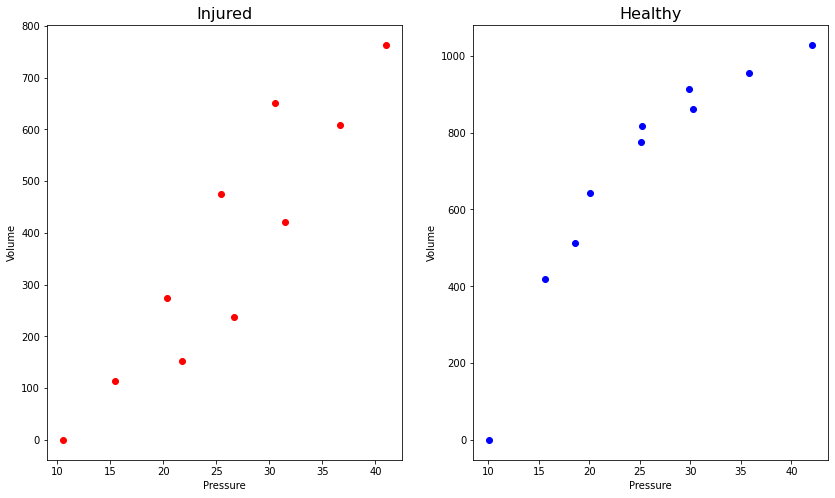

In [14]:
fig, axs = plt.subplots(1,2, figsize = (14,8))

data = [d_data, s_data]
xlabels = ["Pressure","Pressure"]
ylabels = ["Volume","Volume"]
subtitles = ["Injured", "Healthy"]
colors = ["r","b"]

for ax, d, xlabel, ylabel, subtitle, color in zip(axs.flatten(), data, xlabels, ylabels, subtitles, colors):
    ax.scatter(d[:,0], d[:,1], c = color)
    ax.set_title(subtitle, fontsize = 16)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

## Fitting Sigmoid

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [15]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

print('Total number of ventilation cycles: ' + str(int(len(d_data[:,0])/2)))

numero_de_ciclos = 3
pontos_por_ciclo = 5
flag_interpolate = True
flag_display_data = False
metodo = 'dogbox'    # ‘lm’, ‘trf’, ‘dogbox’

print('Using' , numero_de_ciclos, 'cycles')

d_data_interval = d_data[0:numero_de_ciclos*2:2,:]


# Verificando PEEP mínima e máxima no intervalo desejado
p_min = np.min(d_data_interval[:,0])
p_max = np.max(d_data_interval[:,0])



if flag_interpolate: # interpolando pressoes intermediarias
    pressure_vals = np.linspace(p_min,p_max,1+(numero_de_ciclos-1)*pontos_por_ciclo,endpoint=True)
    d_vols_used = np.interp(pressure_vals,d_data_interval[:,0],d_data_interval[:,1])
    d_data_used = np.vstack((pressure_vals, d_vols_used)).T
else: # Usando apenas as PEEPs no intervalo desejado
    d_data_used = d_data_interval

if flag_display_data:
    print("Pressure interval (cmH2O): ", (p_min,p_max))
    print("dados:\n",d_data)
    print("intervalo:\n",d_data_interval)
    print("d_data_used:\n",d_data_used)

def func(x, a, b, c, d):
    return a + b/(1 + np.exp(-(x-c)/d))

# o método LMS está apresentando uma estimativa muito ruim dependendo dos ciclos utilizados... descobrir porque...
d_popt, _ = curve_fit(func, d_data_used[:,0],  d_data_used[:,1], method = metodo)

print("Estimated Lung Capacity: {:.0f} mL".format(d_popt[1]))

Total number of ventilation cycles: 5
Using 3 cycles
Estimated Lung Capacity: 1169 mL


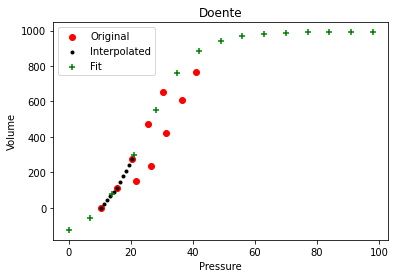

fit: a=-178.68, b=1169.11, c=23.97, d= 7.89


In [16]:
pressures = range(0,100,7)

plt.title("Doente")
plt.scatter(d_data[:,0], d_data[:,1], c = 'r', label = "Original")
plt.scatter(d_data_used[:,0], d_data_used[:,1], c = 'k', marker = '.', label = "Interpolated")
plt.scatter(pressures, func(pressures, *d_popt), c = 'g', marker = '+', label = "Fit")
plt.xlabel('Pressure')
plt.ylabel('Volume')
plt.legend()
plt.show()
print('fit: a=%5.2f, b=%5.2f, c=%5.2f, d=%5.2f' % tuple(d_popt))

### Results
Verificando qual a capacidade pulmonar estimada a cada passo de incremento da PEEP.

A ideia é a seguinte: o médico está fazendo uma manobra de recrutamento alveolar, ou seja, ventilando o paciente alguns ciclos em uma certa PEEP, e em seguida aumenta a PEEP por alguns ciclos para recrutar alvéolos... a pergunta que deve ser respondida é: _todos os alvéolos já estão abertos, ou vale a pena incrementar mais ainda a PEEP?_ Sabemos isso verificando se o volume atual está próximo da capacidade pulmonar total (TLC)estimada ou não.

PS: idealmente temos que comparar a TLC com onde a exponencial atual vai parar, e não com o volume máximo do ciclo (ou seja, nos interessa a diferença entre onde a sigmoóide termina e onde a exponencial atual termina... lembrar que a sigmoide na verdade é formada por vários trechos de exponenciais). Verificar como fazer isso...



---


* **A estimativa com 4 ciclos fica fora do esperado (seria algum erro na coleta dos dados?), mas a com 3 ciclos e a com 5 ciclos ficam muito próximas!**
* **Alguns números de pontos_por_ciclo dão erro (ex: 5)... descobrir porque...**



In [20]:

def func_sigm(x, a, b, c, d):
    return a + b/(1 + np.exp(-(x-c)/d))

def estima(d_data, numero_de_ciclos, pontos_por_ciclo, metodo, flag_interpolate, funcao):
    d_data_interval = d_data[0:numero_de_ciclos*2:2,:]
    # Verificando PEEP mínima e máxima no intervalo desejado
    p_min = np.min(d_data_interval[:,0])
    p_max = np.max(d_data_interval[:,0])

    if flag_interpolate: # interpolando pressoes intermediarias
        pressure_vals = np.linspace(p_min,p_max,1+(numero_de_ciclos-1)*pontos_por_ciclo,endpoint=True)
        d_vols_used = np.interp(pressure_vals,d_data_interval[:,0],d_data_interval[:,1])
        d_data_used = np.vstack((pressure_vals, d_vols_used)).T
    else: # Usando apenas as PEEPs no intervalo desejado
        d_data_used = d_data_interval
    
    d_popt, _ = curve_fit(funcao, d_data_used[:,0],  d_data_used[:,1], method = metodo)    

    return d_popt

# o método LMS está apresentando uma estimativa muito ruim dependendo dos ciclos utilizados... descobrir porque...
metodo_lst = ['lm', 'trf', 'dogbox']
pontos_por_ciclo_lst = [3,50,200]
nciclos_lst = list(range(3,6)) #Poderiamos passar somente range(3,6)
flag_interpolate = True

# alguns numeros de pontos_por_ciclo dao erro (ex: 5)... descobrir porque...
# estimativa com 'lm' usando 4 ciclos fica bem ruim... descobrir porque...

for pontos_por_ciclo in pontos_por_ciclo_lst: 
    for metodo in metodo_lst:
        print(f"Using method {metodo}, with, {pontos_por_ciclo} points per cycle")
        for nciclos in nciclos_lst:
          dd_popt = estima(d_data,nciclos, pontos_por_ciclo, metodo, flag_interpolate, func_sigm)
          print(f"Estimated Lung Capacity ({nciclos} cycles): {dd_popt[1]:.0f} mL")

Using method lm, with, 3 points per cycle
Estimated Lung Capacity (3 cycles): 153 mL
Estimated Lung Capacity (4 cycles): 65 mL
Estimated Lung Capacity (5 cycles): 1127 mL
Using method trf, with, 3 points per cycle
Estimated Lung Capacity (3 cycles): 1189 mL
Estimated Lung Capacity (4 cycles): 1450 mL
Estimated Lung Capacity (5 cycles): 1127 mL
Using method dogbox, with, 3 points per cycle
Estimated Lung Capacity (3 cycles): 1189 mL
Estimated Lung Capacity (4 cycles): 1450 mL
Estimated Lung Capacity (5 cycles): 1127 mL
Using method lm, with, 50 points per cycle
Estimated Lung Capacity (3 cycles): 1103 mL
Estimated Lung Capacity (4 cycles): 52 mL
Estimated Lung Capacity (5 cycles): 1092 mL
Using method trf, with, 50 points per cycle
Estimated Lung Capacity (3 cycles): 1103 mL
Estimated Lung Capacity (4 cycles): 1408 mL
Estimated Lung Capacity (5 cycles): 1092 mL
Using method dogbox, with, 50 points per cycle
Estimated Lung Capacity (3 cycles): 1103 mL
Estimated Lung Capacity (4 cycles): 